In [61]:
import csv
import wget
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np


Load the data

The “gene effect” file contains the corrected CERES scores, which measure the effect size of knocking out a gene, normalized against the distributions of non-essential and pan-essential genes. Columns are genes, rows are cell lines. A more negative CERES score indicates depletion of the gene in that cell line, indicating that it is an essential gene for cell viability.

For simplicity, we call a gene "effective", if the effect size of that gene is below -0.5.


In [2]:
url = 'https://ndownloader.figshare.com/files/14221385'
filename = 'D:/Uni/JAX/SL/IDGKG-gen/data/gene_effect_corrected.csv' # path to the file

if not os.path.exists(filename):
    filename = wget.download(url)
    
df = pd.read_csv(filename)

In [45]:

#df_tr = pd.read_csv(filename).T
#new_header = df_tr.iloc[0] #grab the first row for the header
#df_tr = df_tr[1:] #take the data less the header row
#df_tr.columns = new_header 

df.head() 

,Unnamed: 0,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZUFSP (221302),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000004,0.134645,0.075536,-0.140209,0.013928,0.029131,-0.147284,0.275829,-0.363633,0.250165,...,-0.125018,-0.145802,-0.095429,-0.396903,0.205685,0.197798,-0.347782,0.212048,0.202099,-0.123465
1,ACH-000005,-0.212445,0.233124,0.044365,0.173837,-0.124389,-0.298849,0.120260,-0.339925,-0.011309,...,-0.142212,-0.377179,-0.109019,-0.544686,0.126581,0.033066,-0.060746,0.443834,-0.091548,0.065104
2,ACH-000007,0.043318,0.066838,-0.036197,0.134781,0.082996,0.119084,0.057116,-0.352541,-0.005800,...,-0.063270,-0.469378,-0.068437,-0.207803,0.158380,0.001434,-0.255654,0.065777,-0.314659,-0.358418
3,ACH-000009,0.070512,0.008430,0.027114,0.055927,0.046325,0.015968,0.053502,-0.498860,0.110794,...,0.114418,-0.374999,-0.204950,-0.196839,0.043411,0.018276,-0.398310,0.151885,-0.124333,-0.391758
4,ACH-000011,0.190935,0.083952,-0.000741,0.353375,-0.037044,-0.205803,0.071275,-0.317310,0.099824,...,0.052517,-0.510975,-0.345998,-0.408631,0.241005,0.141594,-0.177939,0.092722,-0.161591,-0.329937


In [54]:
gene_effect_threshold = -0.5 #threshold from which genes are considered effective
proportion_threshold = 0.25  #threshold below which proportion of cells, genes are considered for SL Interaction


effective_genes_with_right_prop = [] #list of effective genes with proportion below threshold
proportion_effective_genes_in_cell_lines = [] 
number_effective_genes = 0 #number of genes with at least one effect size below threshold
number_effective_genes_in_all_cell_lines = 0 #number of genes with effect sizes less than threshold in all cell lines.


for i in range(1,df.shape[1]):
    col = df.columns[i]
    df_col = df.loc[:,col]  #dataframe corresponding to a gene (column)
    
    gene_effect_df = df_col.loc[df.loc[:,col] < gene_effect_threshold] #dataframe corresponding to a gene(column) with effect sizes below threshold
    proportion_effective_gene_in_cell_lines = gene_effect_df.shape[0] / df.shape[0]
    
    if 0 < proportion_effective_gene_in_cell_lines < proportion_threshold:
        number_effective_genes += 1
        effective_genes_with_right_prop.append(i)
        proportion_effective_genes_in_cell_lines.append(proportion_effective_gene_in_cell_lines)
        
print("Number of genes where 0 < proportion of cells with effect < " + 
      str(proportion_threshold) + ": {}".format(number_effective_genes))

Number of genes where 0 < proportion of cells with effect < 0.25: 7544


So from 9480 genes with effect size smaller than -0.5 in at least one cell line, in 7544 cell lines the proportion of cell lines being effective is below the proportion_threshold!

In [49]:
prop_df = df.iloc[:,effective_genes_with_right_prop]   # df with all genes with the right proportion

In [95]:
prop_df.shape

(558, 7544)

To get the synthetic lethal genes, 

In [70]:
corrMatrix = prop_df.corr()

<class 'pandas.core.frame.DataFrame'>


In [72]:
print(corrMatrix.shape)

(7544, 7544)


In [73]:
corrMatrix.head()

,A3GALT2 (127550),A4GALT (53947),AAAS (8086),AACS (65985),AAED1 (195827),AAK1 (22848),AANAT (15),AAR2 (25980),AARD (441376),AARSD1 (80755),...,ZSCAN22 (342945),ZSCAN25 (221785),ZSCAN30 (100101467),ZSWIM1 (90204),ZSWIM5 (57643),ZSWIM7 (125150),ZSWIM8 (23053),ZYG11B (79699),ZYX (7791),ZZZ3 (26009)
A3GALT2 (127550),1.000000,-0.049641,-0.053367,0.045212,-0.148688,-0.048556,0.067367,0.009396,-0.001669,-0.095312,...,-0.017980,0.024694,-0.008331,0.108811,0.057812,0.085040,-0.058419,0.118316,0.061853,0.058252
A4GALT (53947),-0.049641,1.000000,0.019439,-0.078249,-0.134868,-0.074626,0.062322,-0.029015,-0.082416,-0.017047,...,0.071239,-0.004804,0.075408,-0.045852,0.081226,0.066848,-0.022810,0.071979,0.068863,-0.040602
AAAS (8086),-0.053367,0.019439,1.000000,0.058008,0.005323,0.156493,-0.023839,-0.032554,-0.012459,0.094941,...,-0.057842,-0.012267,-0.028519,0.017358,0.010780,-0.035608,-0.013006,-0.033753,0.072679,0.076262
AACS (65985),0.045212,-0.078249,0.058008,1.000000,-0.028204,0.063793,-0.072323,-0.074037,-0.052142,-0.052601,...,-0.090372,-0.046871,0.004330,-0.038043,0.039557,-0.046258,0.095547,-0.057009,0.073677,-0.029980
AAED1 (195827),-0.148688,-0.134868,0.005323,-0.028204,1.000000,0.161277,-0.096461,-0.001932,0.048281,0.086627,...,-0.000263,-0.028959,-0.081259,-0.112407,-0.113786,0.094858,-0.046492,-0.017905,-0.098964,-0.007160


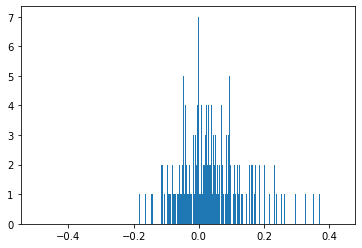

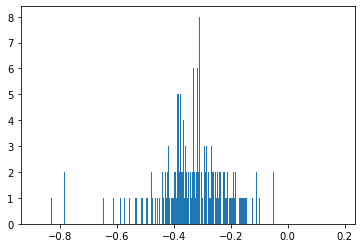

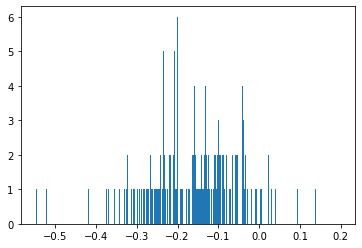

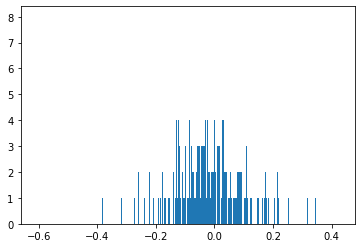

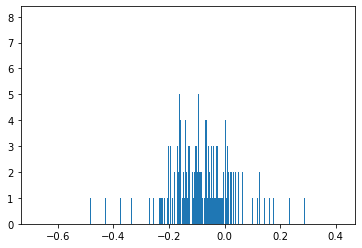

In [96]:
for i in range(1, corrMatrix.shape[1]):
    if i%1500 == 0:
        #print(prop_df.iloc[:,i].nsmallest(5))
        #print("\n")
        plt.hist(prop_df.iloc[:,i], bins = 1000)
        plt.show()

Here we see what the correlation between the genes look like.

In [97]:
1 / 588

0.0017006802721088435